## Define Colors

In [1]:
black = "#000000"
blue = "#16469D"
red = "#BD202D"
green = "#00A14B"
lightblue = "#4B96D1"
orange = "#F16521"
lavender = "#9F6EAF"

evangelista = [black, blue, red, green, lightblue, orange, lavender]

In [2]:
from matplotlib import pyplot as plt
from bgflow.utils import as_numpy
from model import DimerEnergy
import torch
import numpy as np

## Prepare Energy Data

In [4]:

from train import dirname
import glob
import os

def checkpoint_filename(rigid, force_map, train_fraction, version):
    root = dirname(rigid, force_map, train_fraction)
    full_path = os.path.join("allegro_logs", root, f"version_{version}", "checkpoints/*.ckpt")
    checkpoints = glob.glob(full_path)
    assert len(checkpoints) <= 2
    return checkpoints[0]

    
checkpoint = checkpoint_filename(False, "ForceAggregationMap", 0.08, 1)
checkpoint

'allegro_logs/logs_rbf200_random_weights_randn/rigid:False_ForceAggregationMap_trainfraction0.0800/version_1/checkpoints/epoch=369-step=23310.ckpt'

In [5]:
def load_and_evaluate_energy(checkpoint, x=torch.linspace(0.1, 0.7, 100)):
    net = DimerEnergy.load_from_checkpoint(checkpoint).cgmodel
    x = x.to(net.weights)
    rs = torch.zeros(len(x), 2, 3).to(net.weights)
    rs[:, 1, 0] = x
    e = net.energy(rs)
    #print(e)
    e = as_numpy(e)
    x = as_numpy(x)
    emin = e[np.logical_and(x>0.25, x<0.35)].min()
    e -= emin
    return e.flatten()

def load_energies(rigid, aggregation, train_fraction, x=torch.linspace(0.1, 0.7, 100)):
    energies = []
    force_map = "ForceAggregationMap" if aggregation else "ForceSliceMap"
    for version in range(10):
        try:
            checkpoint = checkpoint_filename(rigid, force_map, train_fraction, version)
            energy = load_and_evaluate_energy(checkpoint, x=x)
            energies.append(energy)
        except IndexError:
            continue
    return np.array(energies)

    

## Define Energy Plotting Functions

In [6]:
def plot_energy(energies, ax, color=None, **kwargs):
    mean = energies.mean(axis=0)
    std = energies.std(axis=0) / np.sqrt(len(energies))
    ax.plot(np.linspace(0.1, 0.7, 100), mean, color=color, **kwargs)
    ax.fill_between(np.linspace(0.1, 0.7, 100), energies.min(axis=0), energies.max(axis=0), color=color, alpha=0.4)    
    #ax.fill_between(mean - std, mean + std)

def plot_reference(ax, rigid=False):
    filename = f"pmf_{'rigid' if rigid else 'flexible'}_data.npz"
    pmf = np.load(filename)
    r, w = pmf['xs'], pmf['us']
    ax.plot(r, w, ":", color="black", lw=2, label="empirical")
    ax.set_xlim(0.23, 0.5)
    ax.set_ylim(0, 10)
    ax.set_xlabel("O-O distance [nm]")


## Prepare Force Data

In [7]:
import numpy as np

def norm(r):
    if isinstance(r, torch.Tensor):
        return torch.linalg.norm(r, dim=-1)
    else:
        return np.linalg.norm(r, axis=-1)

def dot(a,b):
    if isinstance(a, torch.Tensor):
        return torch.sum(a*b, dim=-1)
    else:
        return np.sum(a*b, axis=-1)
    
    
def cg_distance(r):
    return norm(r[...,0,:] - r[...,1,:])

def cg_radial_force(f, r):
    distance_vector = r[...,0,:] - r[...,1,:]
    distance_vector = distance_vector / norm(distance_vector)[..., None]
    radial_force0 = dot(f[...,0,:], distance_vector)
    radial_force1 = dot(f[...,1,:], distance_vector)
    radial_force = radial_force0 - radial_force1
    return radial_force

def cg_project_onto_distance(r, f):
    return cg_distance(r), cg_radial_force(f, r)

slice_mapping = np.array([[1, 0, 0, 0, 0, 0],[0, 0, 0, 1, 0, 0]])
agg_mapping = np.array([[1, 1, 1, 0, 0, 0],[0, 0, 0, 1, 1, 1]])

from bgmol.datasets import WaterDimerFlexibleTIP3P, WaterDimerRigidTIP3P

dataset = WaterDimerFlexibleTIP3P(read=True)
sliced_radial_forces_flexible = cg_project_onto_distance(
    slice_mapping @ dataset.xyz, slice_mapping @ dataset.forces
)
aggregated_radial_forces_flexible = cg_project_onto_distance(
    slice_mapping @ dataset.xyz, agg_mapping @ dataset.forces
)

dataset = WaterDimerRigidTIP3P(read=True)
sliced_radial_forces_rigid = cg_project_onto_distance(
    slice_mapping @ dataset.xyz, slice_mapping @ dataset.forces
)
aggregated_radial_forces_rigid = cg_project_onto_distance(
    slice_mapping @ dataset.xyz, agg_mapping @ dataset.forces
)



  0%|          | 0/7263250 [00:00<?, ?it/s]

Extracting /srv/public/kraemea88/projects/noise-cancelling/aggforce/examples/water/WaterDimerFlexibleTIP3P.tgz to /srv/public/kraemea88/projects/noise-cancelling/aggforce/examples/water


  0%|          | 0/7076924 [00:00<?, ?it/s]

Extracting /srv/public/kraemea88/projects/noise-cancelling/aggforce/examples/water/WaterDimerRigidTIP3P.tgz to /srv/public/kraemea88/projects/noise-cancelling/aggforce/examples/water


## Define Force Plotting Functions

In [8]:
def plot_forces(distances, forces, ax, color=None, **kwargs):
    ax.plot([0,1], [0,0], color="black", lw=0.8)
    ax.scatter(distances, forces, s=0.001, color=color, **kwargs)
    ax.set_ylim(-1000, 3000)
    ax.set_xlim(0.23, 0.5)
    

## Big Plot

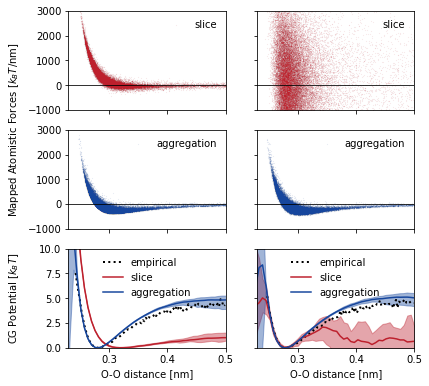

In [12]:
fig, axess = plt.subplots(3, 2, figsize=(6.2,6.2), sharex=True, sharey="row")

RIGID = True

axes = axess[:,0]
ax = axes[0]
#ax.set_title("RIGID")
plot_forces(*sliced_radial_forces_rigid, ax, color=red, label="slice")
ax.legend(frameon=False)
ax.set_ylabel("Mapped Atomistic Forces [$k_B T$/nm]")
ax.yaxis.set_label_coords(-0.3,-0.2)

ax = axes[1]
plot_forces(*aggregated_radial_forces_rigid, axes[1], color=blue, label="aggregation")
ax.legend(frameon=False)

ax = axes[2]
plot_reference(ax, rigid=RIGID)
plot_energy(load_energies(rigid=RIGID, aggregation=False, train_fraction=0.08), ax, color=red, label="slice")
plot_energy(load_energies(rigid=RIGID, aggregation=True, train_fraction=0.08), ax, blue, label="aggregation")
ax.legend(frameon=False, loc="upper center")
ax.set_ylabel("CG Potential [$k_B T$]")
ax.yaxis.set_label_coords(-0.3,0.5)


RIGID = False

axes = axess[:,1]
ax = axes[0]
plot_forces(*sliced_radial_forces_flexible, ax, color=red, label="slice")
ax.legend(frameon=False)

ax = axes[1]
plot_forces(*aggregated_radial_forces_flexible, axes[1], color=blue, label="aggregation")
ax.legend(frameon=False)

ax = axes[2]
plot_reference(ax, rigid=RIGID)
plot_energy(load_energies(rigid=RIGID, aggregation=False, train_fraction=0.08), ax, color=red, label="slice")
plot_energy(load_energies(rigid=RIGID, aggregation=True, train_fraction=0.08), ax, blue, label="aggregation")
ax.legend(frameon=False, loc="upper center")

fig.savefig("water_results_both.png", dpi=360, bbox_inches="tight")

## Prepare Training Data

In [13]:
from extract_tboard import tflog2pandas 

In [14]:
def event_filename(rigid, force_map, train_fraction, version):
    root = dirname(rigid, force_map, train_fraction)
    full_path = os.path.join("allegro_logs", root, f"version_{version}", "events.out*")
    events = glob.glob(full_path)
    assert len(events) <= 2
    return events[0]

def load_val_losses(rigid, aggregation, train_fraction, x=torch.linspace(0.1, 0.7, 100)):
    val_losses = []
    force_map = "ForceAggregationMap" if aggregation else "ForceSliceMap"
    for version in range(10):
        try:
            efile = event_filename(rigid, force_map, train_fraction, version)
            data = tflog2pandas(efile)
            data = data[data.metric == "val_loss"]
            step = np.array(data.step)
            val_loss = np.array(data.value)
            val_losses.append([step, val_loss])
        except IndexError:
            continue
    return val_losses


In [15]:
val_losses_aggregation_rigid = load_val_losses(rigid=True, aggregation=True, train_fraction=0.08)
val_losses_slice_rigid = load_val_losses(rigid=True, aggregation=False, train_fraction=0.08)
val_losses_aggregation_flexible = load_val_losses(rigid=False, aggregation=True, train_fraction=0.08)
val_losses_slice_flexible = load_val_losses(rigid=False, aggregation=False, train_fraction=0.08)

In [16]:
print([len(l) for s, l in val_losses_slice_flexible])
print([len(l) for s, l in val_losses_slice_rigid])

[1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]
[1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]


In [56]:

def plot_losses(losses, ax, color=None, luft=20, lowerluft=10, **kwargs):
    steps = losses[0][0]
    assert all(np.allclose(step, losses[0][0]) for step, _ in losses)
    #steps = 
    losses = np.array([valloss for _, valloss in losses])
    mean = np.mean(losses, axis=0)
    ax.plot(steps, mean, color=color, lw=2, **kwargs)
    ax.plot(steps, losses.T, "-", color=black, lw=0.5, alpha=0.5)
    #ax.fill_between(steps, losses.min(axis=0), losses.max(axis=0), color=color, alpha=0.4)    
    ax.set_ylim(mean.min() - lowerluft, mean.min() + luft)
    ax.semilogx()
    return losses



## Plot Validation Error

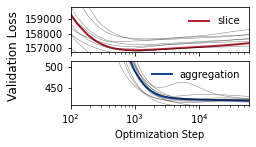

In [57]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(3.2,1.8), sharex=True)
plot_losses(val_losses_aggregation_flexible, ax2, color=blue, luft=100, lowerluft=10, label="aggregation")
plot_losses(val_losses_slice_flexible, ax1, color=red, luft=3000, lowerluft=100, label="slice")
ax1.legend(frameon=False, loc="upper right")
ax2.legend(frameon=False, loc="upper right")

if False:
    ax1.spines.bottom.set_visible(False)
    ax2.spines.top.set_visible(False)
    ax1.xaxis.tick_top()
    ax1.tick_params(labeltop=False)  # don't put tick labels at the top
    ax2.xaxis.tick_bottom()
    d = .5  # proportion of vertical to horizontal extent of the slanted line
    kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
                  linestyle="none", color='k', mec='k', mew=1, clip_on=False)
    ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
    ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)

#ax.set_ylim(losses.min() - 1, losses.min() + 20)
ylabel = fig.supylabel("Validation Loss")
ylabel.set_x(-0.15)
ax2.set_xlabel("Optimization Step")
ax2.set_xlim(100,60000)
#fig.yaxis.set_label_coords(-0.3,0.5)

fig.savefig("validation_losses.png", dpi=360, bbox_inches="tight")